# Impact of price concessions in NHS in England

## 1.  Import data into notebook

In [1]:
#import tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from IPython.display import HTML
from datetime import datetime

#Suppress scientific notation#
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
#import from bigquery, including estriol correction
projectid = "ebmdatalab"

df = pd.read_gbq("""
SELECT
  DATE(presc.month) AS month,
  ncso.bnf_code,
  ncso.dmd_name,
  CASE
    WHEN ncso.bnf_code='0702010F0AAACAC' THEN SUM(presc.quantity/80) --adjusting estriol cream quantity
    ELSE SUM(presc.quantity)
  END AS quantity,
  ncso.dmd_quantity,
  ncso.ncso_price,
  dt.dt_price,
  SUM(CASE
      WHEN ncso.bnf_code='0702010F0AAACAC' THEN (presc.quantity/80)*((ncso.ncso_price-dt.dt_price)/ncso.dmd_quantity)/100 --adjusting estriol cream quantity
      ELSE presc.quantity*((ncso.ncso_price-dt.dt_price)/ncso.dmd_quantity)/100 END) AS excess_cost
FROM
  richard.price_concessions AS ncso
INNER JOIN
  hscic.normalised_prescribing_standard AS presc
ON
  presc.month=ncso.month
  AND presc.bnf_code=ncso.bnf_code
INNER JOIN
  richard.drug_tariff AS dt
ON
  dt.month = ncso.month
  AND dt.vmpp = ncso.vmpp
GROUP BY
  month,
  ncso.bnf_code,
  ncso.dmd_name,
  ncso.ncso_price,
  dt.dt_price,
  ncso.dmd_quantity
ORDER BY
  month,
  ncso.dmd_name
""", projectid,dialect='standard')

Requesting query... ok.
Job ID: job_XEu74pQvUXI40wG4-ErKs_-JUbom
Query running...
  Elapsed 11.44 s. Waiting...
  Elapsed 21.94 s. Waiting...
Query done.
Processed: 33.0 GB
Standard price: $0.16 USD

Retrieving results...
  Got page: 1; 100% done. Elapsed 22.71 s.
Got 854 rows.

Total time taken 22.73 s.
Finished at 2017-12-05 14:27:00.


In [3]:
#create month as index for graphing purposes
df['month'] = pd.to_datetime(df['month'])
df.index = df['month']
del df['month']

## 2. Total number of formulations subject to price concession

In [4]:
#import from bigquery, including estriol correction
projectid = "ebmdatalab"
total_df = pd.read_gbq("""
SELECT
  DATE(month) AS month,
  COUNT(vmpp) AS number_of_products
FROM
  richard.price_concessions
  group by month
  order by month
""", projectid,dialect='standard')

Requesting query... ok.
Job ID: job_LE7GztANFHkP6qdJpdKg44HzC48Z
Query running...
Query done.
Cache hit.

Retrieving results...
Got 39 rows.

Total time taken 1.06 s.
Finished at 2017-12-05 14:27:22.


In [20]:
#create grouped df for excess cost
total_df['month'] = pd.to_datetime(total_df['month'])
total_df.index = total_df['month']
del total_df['month']

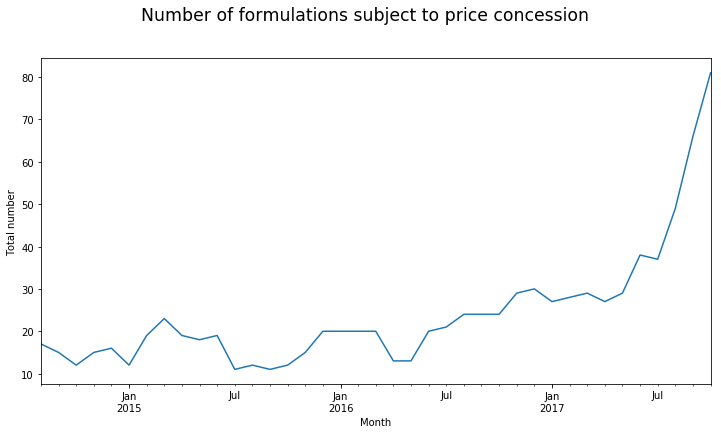

In [22]:
#Showing number of products affected per month
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
total_df.plot(ax=ax, legend=False, y='number_of_products')
#fmt = '{x:,.0f}'
#tick = mtick.StrMethodFormatter(fmt)
#ax.yaxis.set_major_formatter(tick)
ax.set_xlabel("Month")
ax.set_ylabel("Total number")
plt.suptitle('Number of formulations subject to price concession', x=0.5, y=1, ha='center', fontsize='xx-large')
plt.show()

## 2.  Showing change over time in excess cost

In [5]:
#create grouped df for excess cost
time_df=df.groupby([df.index]).sum()
#create table version (without index and other columns and format number)
tbl_time_df = time_df[['excess_cost']].copy()
tbl_time_df.reset_index(level=0, inplace=True)
tbl_time_df['excess_cost'] = tbl_time_df['excess_cost'].map('£{:,.0f}'.format) 

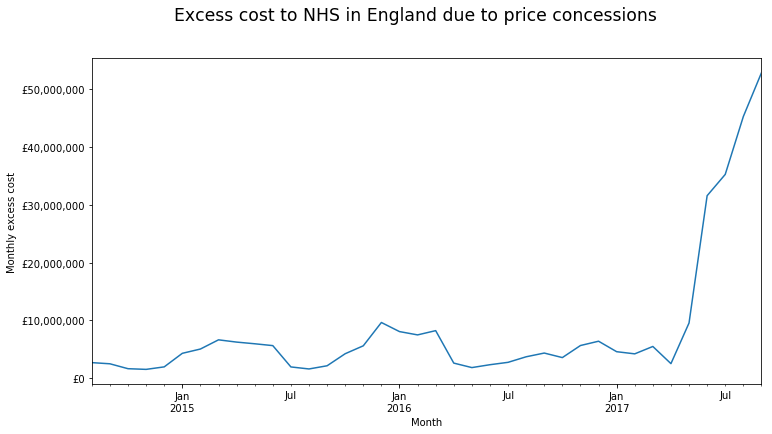

In [6]:
#Plot excess cost chart
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
time_df.plot(ax=ax, legend=False, y='excess_cost')
fmt = '£{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
ax.set_xlabel("Month")
ax.set_ylabel("Monthly excess cost")
plt.suptitle('Excess cost to NHS in England due to price concessions', x=0.5, y=1, ha='center', fontsize='xx-large')
plt.show()

In [29]:
#produce HTML table of costs
tbl_time_df["month"] = tbl_time_df["month"].dt.strftime("%B %Y")
HTML(tbl_time_df.to_html(index=False, classes='table table-striped'))


month,excess_cost
August 2014,"£2,688,762"
September 2014,"£2,485,712"
October 2014,"£1,636,428"
November 2014,"£1,519,747"
December 2014,"£1,952,294"
January 2015,"£4,297,831"
February 2015,"£5,040,827"
March 2015,"£6,631,585"
April 2015,"£6,240,501"
May 2015,"£5,951,586"


## 3.  Showing cumulative costs in 2017-18

In [27]:
#create 2017-18 dataframe
fy_time_df= time_df.loc[time_df.index >= '2017-04-01']
fy_time_df['cumulative_cost'] = fy_time_df.excess_cost.cumsum()

#create table version (without index and other columns and format number)
tbl_fy_time_df = fy_time_df[['excess_cost', 'cumulative_cost']].copy()
tbl_fy_time_df.reset_index(level=0, inplace=True)
tbl_fy_time_df['excess_cost'] = tbl_fy_time_df['excess_cost'].map('£{:,.0f}'.format)
tbl_fy_time_df['cumulative_cost'] = tbl_fy_time_df['cumulative_cost'].map('£{:,.0f}'.format) 

C:\Users\racro\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


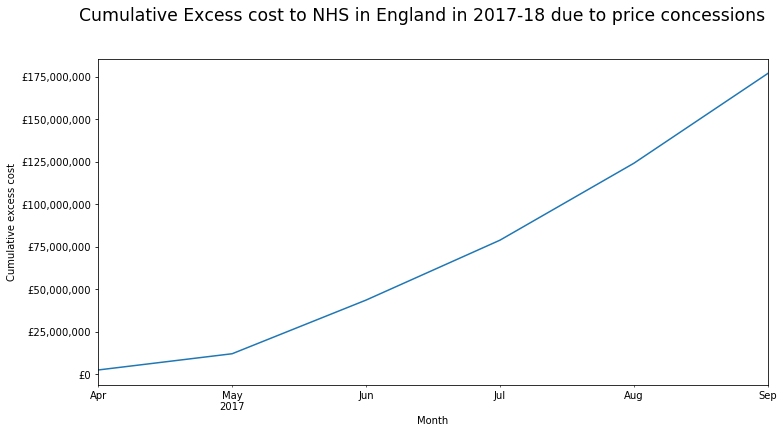

In [9]:
#draw graph
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
fy_time_df.plot(ax=ax, legend=False, y='cumulative_cost')
fmt = '£{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
ax.set_xlabel("Month")
ax.set_ylabel("Cumulative excess cost")
plt.suptitle('Cumulative Excess cost to NHS in England in 2017-18 due to price concessions', x=0.5, y=1, ha='center', fontsize='xx-large')
plt.show()

In [28]:
#produce HTML table of costs
tbl_fy_time_df["month"] = tbl_fy_time_df["month"].dt.strftime("%B %Y")
HTML(tbl_fy_time_df.to_html(index=False, classes='table table-striped'))

month,excess_cost,cumulative_cost
April 2017,"£2,513,041","£2,513,041"
May 2017,"£9,549,333","£12,062,374"
June 2017,"£31,573,865","£43,636,239"
July 2017,"£35,258,470","£78,894,709"
August 2017,"£45,271,689","£124,166,398"
September 2017,"£52,830,450","£176,996,848"


## 4. Top 20 Formulations and their costs in 2017-2018

In [11]:
#create 2017-18 dataframe
cfy_df= df.loc[df.index >= '2017-04-01']

In [12]:
#create top 20 of costs grouped by dmd_name
cfy_df=cfy_df.groupby(['dmd_name']).sum()
tbl_cfy_df = cfy_df[['excess_cost']].copy()
tbl_cfy_df.reset_index(level=0, inplace=True)
tbl_cfy_df.sort_values('excess_cost', inplace=True, ascending=False)
tbl_cfy_df=tbl_cfy_df.nlargest(20,'excess_cost')
tbl_cfy_df['excess_cost'] = tbl_cfy_df['excess_cost'].map('£{:,.0f}'.format)

In [13]:
HTML(tbl_cfy_df.to_html(index=False, classes='table table-striped'))

dmd_name,excess_cost
Sumatriptan 50mg tablets,"£17,418,879"
Olanzapine 10mg tablets,"£12,853,700"
Gabapentin 300mg capsules,"£9,325,831"
Quetiapine 100mg tablets,"£9,137,526"
Quetiapine 25mg tablets,"£8,912,723"
Mefenamic acid 500mg tablets,"£8,758,719"
Levetiracetam 500mg tablets,"£8,720,187"
Sumatriptan 100mg tablets,"£6,256,685"
Quetiapine 200mg tablets,"£6,195,682"
Olanzapine 5mg tablets,"£5,998,957"


## 5. Impact on individual CCGs in 2017-2018

In [44]:
#import from bigquery, including estriol correction
projectid = "ebmdatalab"

ccg_df = pd.read_gbq("""
SELECT
  DATE(presc.month) AS month,
  ccg.code,
  ccg.name,
  ncso.bnf_code,
  ncso.dmd_name,
  CASE
    WHEN ncso.bnf_code='0702010F0AAACAC' THEN SUM(presc.quantity/80) --adjusting estriol cream quantity
    ELSE SUM(presc.quantity)
  END AS quantity,
  ncso.dmd_quantity,
  ncso.ncso_price,
  dt.dt_price,
  SUM(CASE
      WHEN ncso.bnf_code='0702010F0AAACAC' THEN (presc.quantity/80)*((ncso.ncso_price-dt.dt_price)/ncso.dmd_quantity)/100 --adjusting estriol cream quantity
      ELSE presc.quantity*((ncso.ncso_price-dt.dt_price)/ncso.dmd_quantity)/100 END) AS excess_cost
FROM
  richard.price_concessions AS ncso
INNER JOIN
  hscic.normalised_prescribing_standard AS presc
ON
  presc.month=ncso.month
  AND presc.bnf_code=ncso.bnf_code
INNER JOIN
  richard.drug_tariff AS dt
ON
  dt.month = ncso.month
  AND dt.vmpp = ncso.vmpp
INNER JOIN
  hscic.ccgs AS ccg
ON
  presc.pct = ccg.code
WHERE
  ccg.org_type='CCG'
  and presc.month>='2017-04-01 00:00:00'
GROUP BY
  month,
  ncso.bnf_code,
  ncso.dmd_name,
  ncso.ncso_price,
  dt.dt_price,
  ncso.dmd_quantity,
  ccg.code,
  ccg.name
ORDER BY
  month,
  ncso.dmd_name
  """, projectid,dialect='standard')

Requesting query... ok.
Job ID: job_fW9ctJBgmSWIszEPR3bfuwh04wHC
Query running...
Query done.
Cache hit.

Retrieving results...
  Got page: 1; 70% done. Elapsed 7.05 s.
  Got page: 2; 100% done. Elapsed 9.28 s.
Got 49727 rows.

Total time taken 10.28 s.
Finished at 2017-12-05 15:33:51.


In [49]:
total_ccg_df=ccg_df.groupby(['name']).sum()
total_ccg_df=total_ccg_df.drop(['quantity','dmd_quantity','ncso_price','dt_price'], axis=1)

In [51]:
total_ccg_df.reset_index(level=0, inplace=True)
total_ccg_df.sort_values('excess_cost', inplace=True, ascending=False)


In [52]:
total_ccg_df['excess_cost'] = total_ccg_df['excess_cost'].map('£{:,.0f}'.format)

In [53]:
HTML(total_ccg_df.to_html(index=False, classes='table table-striped'))

name,excess_cost
"NHS NORTHERN, EASTERN AND WESTERN DEVON CCG","£3,107,829"
NHS CAMBRIDGESHIRE AND PETERBOROUGH CCG,"£2,578,054"
NHS DORSET CCG,"£2,538,271"
NHS LIVERPOOL CCG,"£2,429,095"
NHS NENE CCG,"£2,285,420"
NHS BIRMINGHAM CROSSCITY CCG,"£2,238,652"
NHS MANCHESTER CCG,"£2,207,458"
NHS GLOUCESTERSHIRE CCG,"£2,002,603"
NHS OXFORDSHIRE CCG,"£1,917,796"
NHS NEWCASTLE GATESHEAD CCG,"£1,790,576"
